In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import get_data
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.eval.calibration import analyze_calibration

In [3]:
X, y = get_data(
    T=1.0,
    dt=0.1,
    N=2_000,
    break_on_impact=False
)

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024_03_25)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{y_train.shape=}')
print(f'{y_val.shape=}')


100%|██████████| 2000/2000 [00:01<00:00, 1108.90it/s]

X_train.shape=(1600, 10, 3)
X_val.shape=(400, 10, 3)
y_train.shape=(1600, 17)
y_val.shape=(400, 17)


In [4]:
X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 30])
y_train_tensor.shape=torch.Size([1600, 17])
X_val_tensor.shape=torch.Size([400, 30])
y_val_tensor.shape=torch.Size([400, 17])


In [5]:
condition_size = 1024

In [6]:
feature_network = FullyConnectedFeatureNetwork(
    input_size=X_train_tensor.shape[1],
    hidden_sizes=[1024] * 5,
    output_size=condition_size,
    dropout=0.5,
).to(device)

In [7]:
cnf = CondRealNVP(
    size=y_train.shape[1],
    hidden_size=128,
    n_blocks=3,
    n_conditions=condition_size,
    act_norm=True,
    feature_network=feature_network).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=200
)

In [8]:
print(f'Number of parameters: {sum(p.numel() for p in cnf.parameters()):.2e}')

Number of parameters: 5.73e+06


In [9]:
loss_history = {}

In [10]:
train_CondRealNVP(
    model=cnf,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    n_epochs=30_000,
    val_loss_patience=500,
    val_loss_tolerance=1e-4,
    batch_size=256,
    loss_history=loss_history
);

Train: -28.5017 - Val: -22.7711 (avg: -22.8355, min: -23.0257) | lr: 8.00e-05 - Patience: 500/500:  21%|██        | 6220/30000 [03:35<13:42, 28.91it/s]


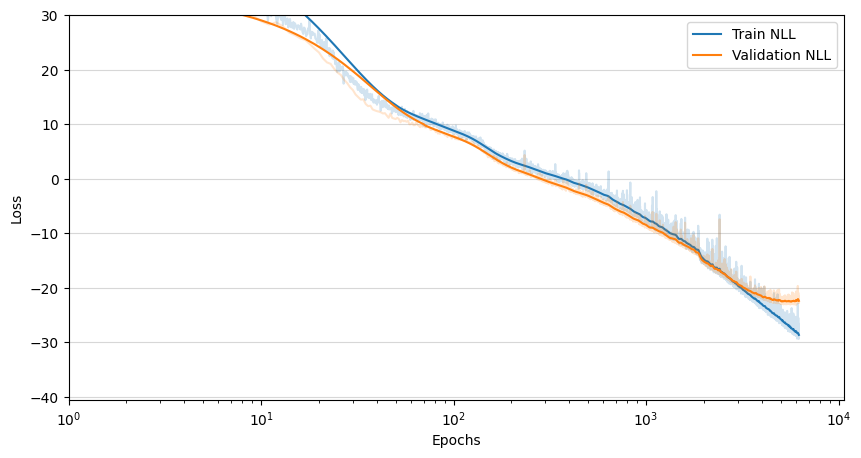

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=100)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=20)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(None, 30)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();

In [10]:
cnf.eval();

In [11]:
N_SAMPLES = 10000

In [12]:
y_hat = cnf.sample(n_samples=N_SAMPLES, y=X_val_tensor[0])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

(10000, 17)

In [13]:
x0_pdf = lambda size: np.random.uniform(0, 10, size=size)
v0_pdf = lambda size: np.random.uniform(-10, 10, size=size) + np.array([0, 0, 9])[None, :]
g_pdf = lambda size: np.random.normal(9.81, 0.1, size=size) * np.array([0, 0, -1])
w_pdf = lambda size: np.random.normal(0, 1, size=size) * np.array([1, 1, 0.1])
b_pdf = lambda size: np.random.uniform(0, 1, size=size)
m_pdf = lambda size: np.random.uniform(0.5, 1.5, size=size)
a_pdf = lambda size: np.random.uniform(0, 0, size=size)

In [14]:
y_prior = np.column_stack([
    x0_pdf(size=(N_SAMPLES, 3)),
    v0_pdf(size=(N_SAMPLES, 3)),
    g_pdf(size=(N_SAMPLES, 3)),
    w_pdf(size=(N_SAMPLES, 3)),
    b_pdf(size=(N_SAMPLES,)),
    m_pdf(size=(N_SAMPLES,)),
    a_pdf(size=(N_SAMPLES, 3))
])

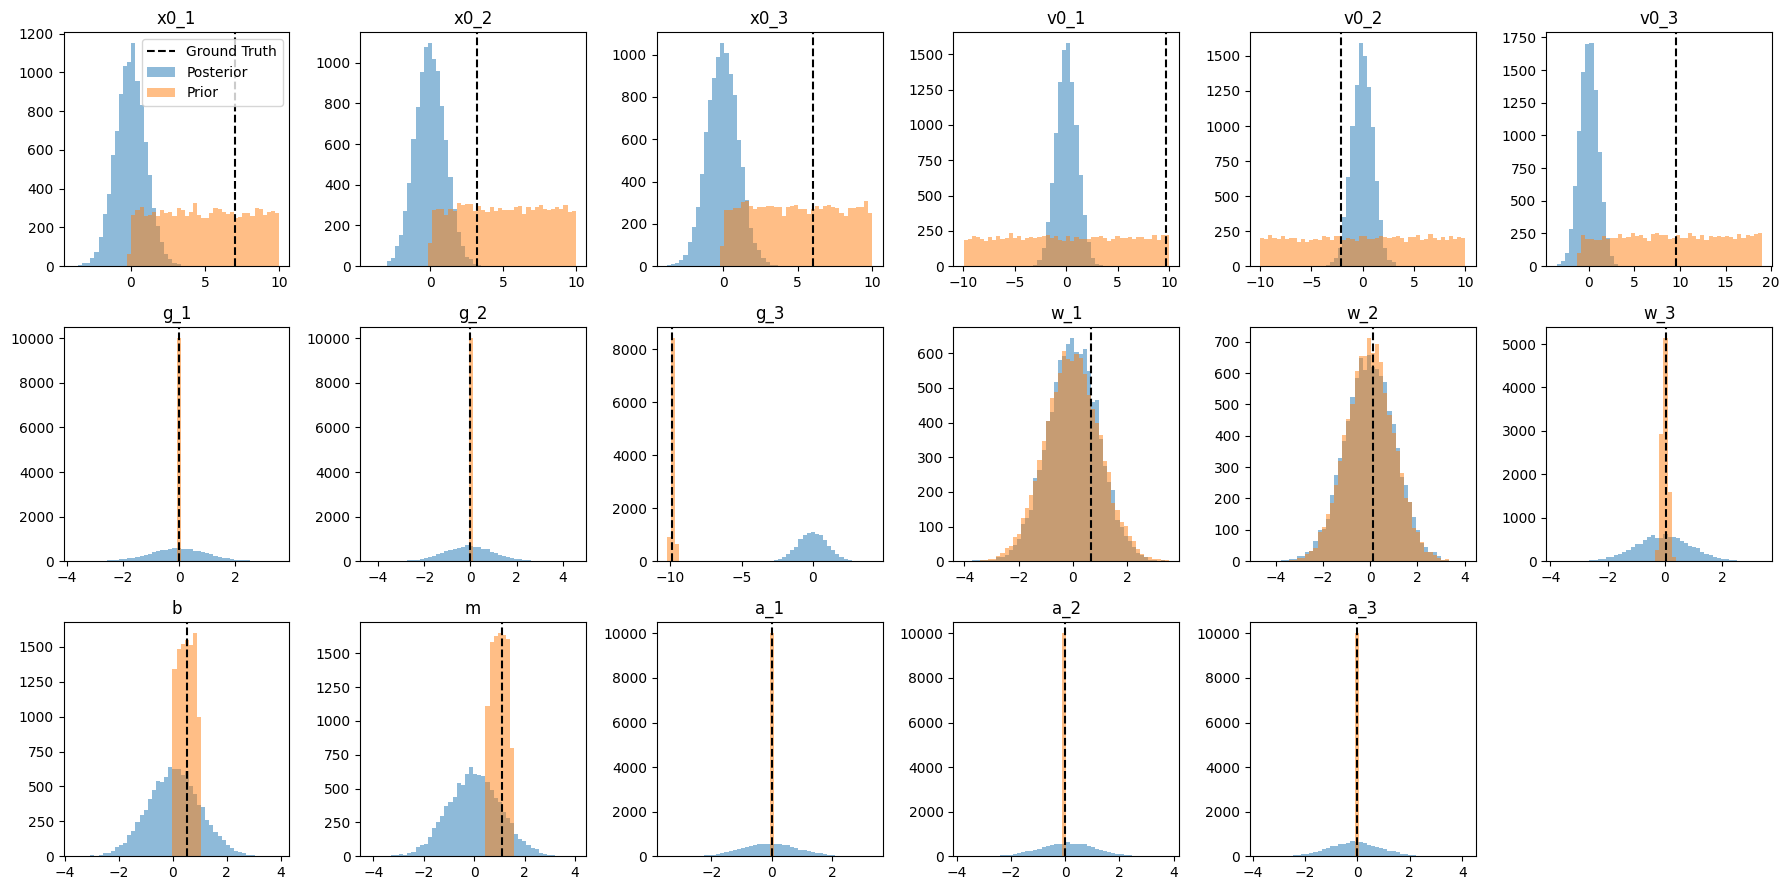

In [15]:
COLS = 6
ROWS = np.ceil(y_hat.shape[1] / COLS).astype(int)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

for i, name in zip(range(y_hat.shape[1]), ['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3']):
    vmin = np.min([y_hat[:, i], y_prior[:, i]])
    vmax = np.max([y_hat[:, i], y_prior[:, i]])
    ax.flatten()[i].axvline(y_val_tensor[0, i].cpu().detach().numpy(), color='k', linestyle='--', label='Ground Truth')
    ax.flatten()[i].hist(y_hat[:, i], alpha=0.5, color='C0', label='Posterior', bins=50, range=(vmin, vmax))
    ax.flatten()[i].set_title(name)

    # Show the prior
    ax.flatten()[i].hist(y_prior[:, i], alpha=0.5, color='C1', label='Prior', bins=50, range=(vmin, vmax))

for i in range(y_hat.shape[1], COLS * ROWS):
    ax.flatten()[i].axis('off')

ax[0, 0].legend()

fig.tight_layout();

# Calibration

In [16]:
from scipy.stats import binom

In [17]:
N_samples = 10_000

In [18]:
X_cal, y_cal = get_data(
    T=1.0,
    dt=0.1,
    N=N_samples,
    break_on_impact=False
)

X_cal_tensor = torch.tensor(X_cal.reshape(X_cal.shape[0], -1), dtype=torch.float32).to(device)
y_cal_tensor = torch.tensor(y_cal, dtype=torch.float32).to(device)

100%|██████████| 10000/10000 [00:08<00:00, 1139.90it/s]


In [19]:
cnf.eval();

In [20]:
M_samples = 5_000

In [21]:
y_cal_ranks = analyze_calibration(
    model=cnf,
    X=X_cal_tensor,
    y=y_cal_tensor,
    M_samples=M_samples,
    batch_size=100,
    device=device,
    output_device='cpu',
)

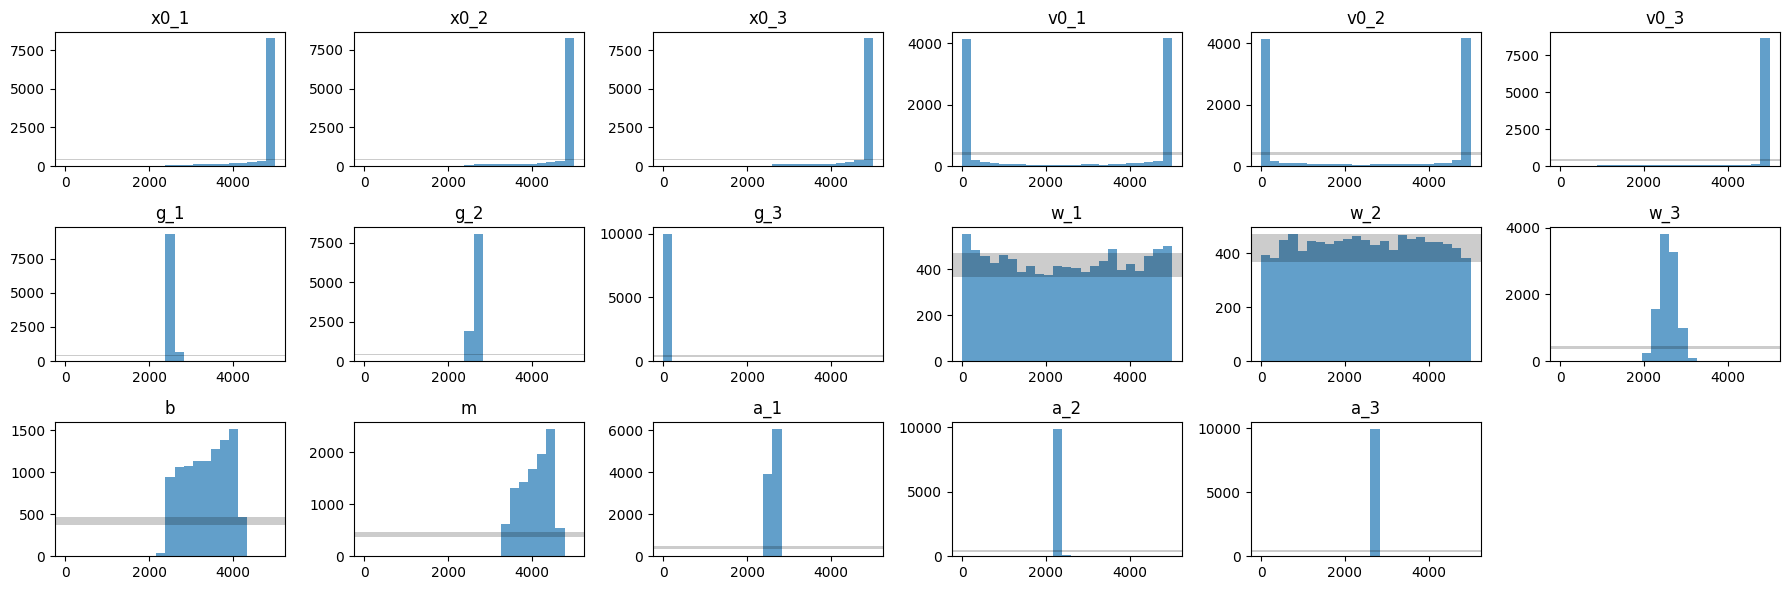

In [23]:
# Plot a histogram of the indices for each of the three parameters
COLS = 6
ROWS = np.ceil(y_cal_ranks.shape[1] / COLS).astype(int)

n_bins = 24
binomial_interval = 0.99

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

endpoints = binom.interval(binomial_interval, N_samples, 1 / n_bins)

n_bins_outliers = 0
n_bins_total = 0

for i, ax, name in zip(range(y_cal_ranks.shape[1]), axes.flatten(), ['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3']):
    hist = ax.hist(y_cal_ranks[:, i].detach().cpu().numpy(), bins=np.linspace(0, M_samples, n_bins), alpha=0.7, color='C0')

    # Count how many bins are outside the interval
    n_bins_outliers += np.sum(hist[0] < endpoints[0]) + np.sum(hist[0] > endpoints[1])
    n_bins_total += n_bins

    ax.axhspan(endpoints[0], endpoints[1], facecolor="k", alpha=0.2)

    ax.set_title(name)

for i in range(y_cal_ranks.shape[1], COLS * ROWS):
    axes.flatten()[i].axis('off')

fig.tight_layout()

In [45]:
print(f'Bins outside the interval: {n_bins_outliers} / {n_bins_total} ({n_bins_outliers / n_bins_total:.2%})')

Bins outside the interval: 15 / 408 (3.68%)


In [46]:
# Calculate the CDF 
def CDF(sorted_arrray_indices, t, M):
    N = sorted_arrray_indices.shape[0]
    t = t * M
    return np.sum(sorted_arrray_indices[:, :, None] <= t[None, None, :], axis=0) / N

def brownian_confidence_interval(t):
    return np.sqrt(t * (1 - t))

t_divisions = 100
t_linspace = np.linspace(0, 1, t_divisions)

cdf = CDF(y_hat_all_sorted_indices_true.cpu().numpy(), t_linspace, M_samples)

residuals = cdf - t_linspace

confidence_interval = brownian_confidence_interval(t_linspace)

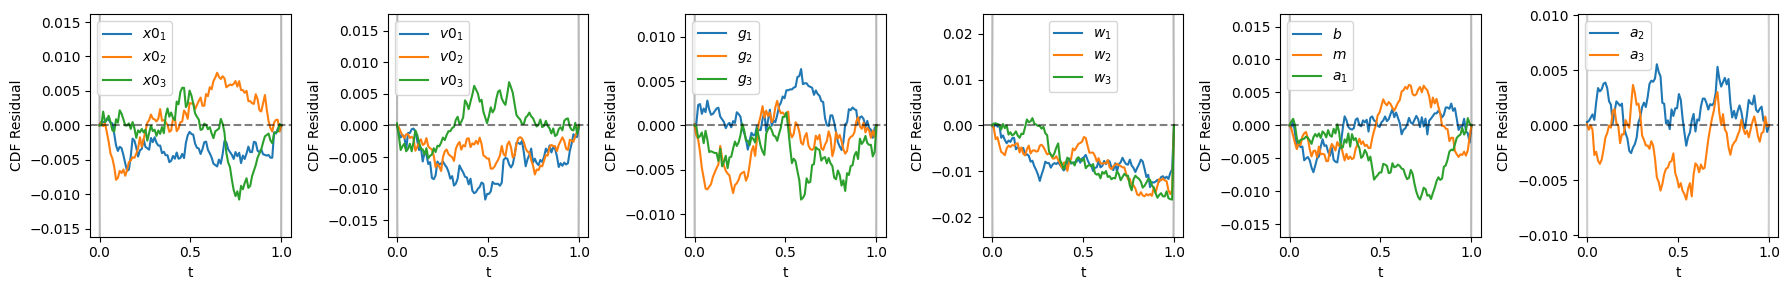

In [47]:
# Plot the residuals for X_0
n_curves_per_plot = 4
N_COLS = 6
N_ROWS = np.ceil(np.ceil(y_hat_all_sorted_indices_true.shape[1] / n_curves_per_plot) / N_COLS).astype(int)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 3, N_ROWS * 3))

for indices, ax, param_names in zip(
    np.array_split(range(y_hat_all_sorted_indices_true.shape[1]), N_ROWS * N_COLS),
    axes.flatten(),
    np.array_split(['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3'], N_ROWS * N_COLS)):
    
    for j, param_name in zip(indices, param_names):
        ax.plot(t_linspace, residuals[j, :], label=f"${param_name}$")

        ax.plot(t_linspace, confidence_interval, color='black', alpha=0.1)
        ax.plot(t_linspace, -confidence_interval, color='black', alpha=0.1)

    ax.set_xlabel("t")
    ax.set_ylabel("CDF Residual")

    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.legend()

    ylim = max(np.abs(residuals[indices, :].min()), np.abs(residuals[indices, :].max()))

    ax.set_ylim(-ylim * 1.5, ylim * 1.5)

fig.tight_layout()